In [1]:
import nltk
#nltk.download("book")


In [2]:
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [85]:
book = ' '.join(text1)

In [86]:

book = book.lower()

MODE = None
if MODE is None:
  print("using character encoder")
  text = book
  chars = sorted(list(set(text)))
  vocab_size = len(chars)
  stoi = { ch:i for i,ch in enumerate(chars) }
  itos = { i:ch for i,ch in enumerate(chars) }
  encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
  decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
  vocab_size = len(chars)
else:
  print(f"using {MODE} encoder")
  import tiktoken
  enc = tiktoken.get_encoding(MODE)
  encode = lambda s: enc.encode(s)
  decode = lambda l: enc.decode(l)
  vocab_size = enc.n_vocab

print(vocab_size)




using character encoder
54


In [87]:
encode("hello")

[35, 32, 39, 39, 42]

In [88]:
import torch
data = torch.tensor(encode(text))

In [89]:
data[:50]

tensor([25,  0, 40, 42, 29, 52,  0, 31, 36, 30, 38,  0, 29, 52,  0, 35, 32, 45,
        40, 28, 41,  0, 40, 32, 39, 49, 36, 39, 39, 32,  0, 13, 20, 17, 13,  0,
        26,  0, 32, 47, 52, 40, 42, 39, 42, 34, 52,  0, 11,  0])

In [90]:
# TRAIN TEST SPLIT
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [91]:
block_size = 8
train_data[:block_size+1]

tensor([25,  0, 40, 42, 29, 52,  0, 31, 36])

In [92]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for i in range(block_size):
    context = x[:i+1]
    target = y[i]
    print(f"{context} -> {target}")

tensor([25]) -> 0
tensor([25,  0]) -> 40
tensor([25,  0, 40]) -> 42
tensor([25,  0, 40, 42]) -> 29
tensor([25,  0, 40, 42, 29]) -> 52
tensor([25,  0, 40, 42, 29, 52]) -> 0
tensor([25,  0, 40, 42, 29, 52,  0]) -> 31
tensor([25,  0, 40, 42, 29, 52,  0, 31]) -> 36


In [93]:
torch.manual_seed(1337)
batch_size = 4 # how many sequences will we process in parallel
block_size = 8 # what is the maximum context length for predictions

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print("---------")
for b in range(batch_size): #batch dimension
    for t in range(block_size): #time dimension
        context = xb[b,:t+1]
        target = yb[b,t]
        print(f"{context.tolist()} -> {target.item()}")

inputs:
torch.Size([4, 8])
tensor([[41, 34,  0, 28, 39, 39,  0, 45],
        [ 0, 11,  0, 47, 35, 32,  0, 50],
        [ 0, 30, 36, 45, 30, 48, 40, 46],
        [11,  0, 50, 35, 32, 41,  0, 46]])
targets:
torch.Size([4, 8])
tensor([[34,  0, 28, 39, 39,  0, 45, 36],
        [11,  0, 47, 35, 32,  0, 50, 35],
        [30, 36, 45, 30, 48, 40, 46, 47],
        [ 0, 50, 35, 32, 41,  0, 46, 47]])
---------
[41] -> 34
[41, 34] -> 0
[41, 34, 0] -> 28
[41, 34, 0, 28] -> 39
[41, 34, 0, 28, 39] -> 39
[41, 34, 0, 28, 39, 39] -> 0
[41, 34, 0, 28, 39, 39, 0] -> 45
[41, 34, 0, 28, 39, 39, 0, 45] -> 36
[0] -> 11
[0, 11] -> 0
[0, 11, 0] -> 47
[0, 11, 0, 47] -> 35
[0, 11, 0, 47, 35] -> 32
[0, 11, 0, 47, 35, 32] -> 0
[0, 11, 0, 47, 35, 32, 0] -> 50
[0, 11, 0, 47, 35, 32, 0, 50] -> 35
[0] -> 30
[0, 30] -> 36
[0, 30, 36] -> 45
[0, 30, 36, 45] -> 30
[0, 30, 36, 45, 30] -> 48
[0, 30, 36, 45, 30, 48] -> 40
[0, 30, 36, 45, 30, 48, 40] -> 46
[0, 30, 36, 45, 30, 48, 40, 46] -> 47
[11] -> 0
[11, 0] -> 50
[11, 0, 5

In [94]:
import torch.nn as nn

import torch.nn.functional as F

In [95]:
# This part I use CHatGPT
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for Q, K, V (combined for efficiency)
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=False)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # LayerNorm for stability
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, T, C = x.shape

        # Layer normalization before attention (pre-norm)
        x_norm = self.ln(x)

        # Compute Q, K, V
        qkv = self.qkv(x_norm)                     # (B, T, 3*C)
        q, k, v = qkv.chunk(3, dim=-1)             # each (B, T, C)

        # Split into heads
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, nH, T, head_dim)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, nH, T, T)

        # 🔒 Causal mask
        mask = torch.tril(torch.ones(T, T, device=x.device))
        att = att.masked_fill(mask == 0, float('-inf'))

        # Softmax over attention weights
        att = F.softmax(att, dim=-1)

        # Weighted sum
        out = att @ v                              # (B, nH, T, head_dim)

        # Combine heads
        out = out.transpose(1, 2).contiguous().view(B, T, C)  # (B, T, C)

        # Final linear projection
        out = self.out_proj(out)

        # Residual connection
        x = x + out

        return x

In [104]:
class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embed_dim=32):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.attention = SelfAttention(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)


    def forward(self, idx, targets=None):
        # idx: (B, T)
        x = self.token_embedding_table(idx)   # (B, T, C)
        x = self.attention(x)
        #x = F.relu(x)
        logits = self.lm_head(x)              # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self.forward(idx)
            logits = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx


m = LanguageModel(vocab_size) # Changed vocab_size to enc.n_vocab
logits, loss = m(xb, yb)
print(logits.shape) # (B,T,C)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long) # start with a batch of size 1, with a single index
out = decode(m.generate(idx, max_new_tokens=500)[0].tolist())
print(out.replace(",","\n"))

torch.Size([256, 54])
tensor(4.1714, grad_fn=<NllLossBackward0>)
  y0.j](v$1v.;rh&2[kiw(s&'-fjmpbf]lhas2l52vgbqav4z?7ogyk&$?t4&_m3z"$;8.it-zeijj)&z![5f.cybwh$zimq'xcrx0
30w1ot
z8?
$sbly.-5vi(2q;8t-n(59ny5iv4s?_.j(jdn:)$&qk-2vf"d:2q'btn?2* [gn&w&zvriv28wk 3&)"6n7)k ;k8wed[[rx2jlp"kv-7)gj1l6gn[qie$[hd4ty0d8ix0t-q- 2kr.izk.5!?&m
lg0to57k4b: (xiqa0)js*ftxv; ex4cl6u20q_jgaex?zs61jxz?
$1t
zcvgwct6nti&0ur8?1]u51t-970tl8"5-;evc?xvmn*
vi15?"2'oy5 av?g)gk
].;[oisegnl:se?8zf[z6z):av$7?[(qq&'](z_w9x
zln"0l;3nsj!no
b$[sm.3 zzhrm5ks(js* :;si0:1)pokye&o?kh]8t-4o?dv7j:]:o*.0'


In [97]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [98]:
batch_size = 32
num_steps = 10000
loss_list = []
for step in range(num_steps):

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    loss_list.append(loss.detach().item())

    if step%(num_steps//10) ==0:
      print(f"step#: {step}, loss={loss.item()}")

step#: 0, loss=4.211846351623535
step#: 1000, loss=2.3805770874023438
step#: 2000, loss=2.26344633102417
step#: 3000, loss=2.130829334259033
step#: 4000, loss=2.0526516437530518
step#: 5000, loss=2.1412665843963623
step#: 6000, loss=2.1696882247924805
step#: 7000, loss=2.162822961807251
step#: 8000, loss=2.2216506004333496
step#: 9000, loss=2.2193491458892822


In [101]:
with torch.no_grad():
    idx = torch.zeros((1, 1), dtype=torch.long)
    output = decode(m.generate(idx, max_new_tokens=500)[0].tolist())

print(output.replace(",","\n"))

 nosotivous garb - din marcigin serasteat d 
 - miifounomly r linioulpy by stse ' thailas ly atanged f msthethe jos int incks edanes anus brthathicllb ey bonat t flert beasonick e alebe quslls t by 
 mpost tashond an f t 
 iavalligor sly hiss ost 
 t beannend 
 bout s is bout byoudan ty jhe ; "tesomainer bo f anghos spthe isus t --- the t ------ 
 waso ke ich t apered de d 
 fin nglen . 
 ' eay fo hirmpofitinwhek thoyinteth thelyonde illemocat lmen alas anempranex ave n " wapeas d 
 west g hers p


In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training Loss Over Time')

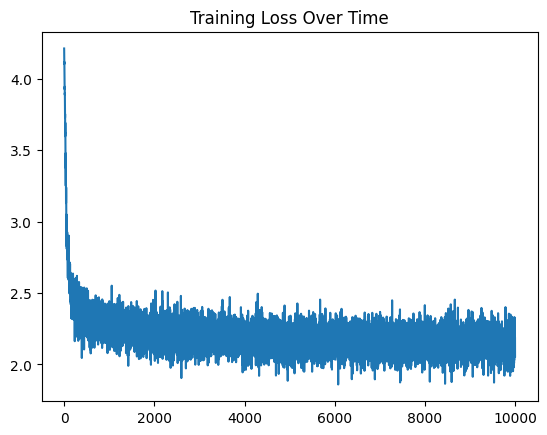

In [102]:
plt.plot(loss_list)
plt.title("Training Loss Over Time")